In [1]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText



data = pd.read_csv('./data/dan_table.csv')

# TrialStart = 0, 1. much more TrialStart == 0 than ==1 
# First lick: Reward Enter
# Next lick: Reward Exit (after they havne't licked for a while) -- not super reliable 

In [2]:
def inv_logit(arr):
    '''Elementwise inverse logit (logistic) function.'''
    return 1 / (1 + np.exp(-arr))

def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal. 
    For details, see Bowling et al. (2009). "A logistic approximation 
    to the cumulative normal distribution."'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)


# def softmax(x):
#     """
#     Compute softmax values for each sets of scores in x.
    
#     Rows are scores for each class. 
#     Columns are predictions (samples).
#     """
#     scoreMatExp = np.exp(np.asarray(x))
#     return scoreMatExp / scoreMatExp.sum(0)

In [3]:
data = data[(data['RecordLoc'] == 1) ]

# Somehow the length of data is different for different RecordLoc... I'm going to use DMS since I'll want to 
# model the neural data from that area later 
#         1 = VTA/SNc -> Dorsomedial Striatum
#         2 = VTA/SNc -> Nucleus Accumbens
#         3 = VTA/ SNc -> Dorsolateral Striatum (forgot i had these)
#         4 = VTA/ SNc -> Dorsomedial Striatum Cell Bodies
#         5 = GFP controls (DMS and NAc together)

In [4]:
# pull out trial by trial info 

data_t = []

for mouse_id in np.unique(data['MouseID']):
    data_small = data[data['MouseID'] == mouse_id]

    trial_starts = np.where(data_small['TrialStart'] == 1)[0]
    num_trials = len(trial_starts)

    for t_i, t in enumerate(trial_starts):

        if t_i == (num_trials - 1):
            trial_end = len(data_small)
        else:
            trial_end = trial_starts[t_i + 1]

        trial_df = data_small[t:trial_end];

#         lever_press = np.where(trial_df['LeverPresentation'] == 1)[0][0]
        if sum(trial_df.IpsLeverPress.values) >  sum(trial_df.ConLeverPress.values):
            action = 'Ips'
        else:
            action = 'Con'

        if sum(trial_df.CSplus.values) >  sum(trial_df.CSneg.values):
            reward = 1
        else:
            reward = 0

        data_t.append([ mouse_id, t_i, action, reward, t, trial_end]) #  lever_press])


    
    
        

In [5]:
df_trials = pd.DataFrame(data_t, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'TrialStart', 'TrialEnd')) # , 'LeverPress'))
df_trials['TrialLen'] = df_trials['TrialEnd'] - df_trials['TrialStart']


In [6]:
NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial'].values

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for s in np.arange(NS):
    c_str[s, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s + 1])['Action'].values
    r[s, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s + 1])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  

standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')


In [8]:
sm = pystan.StanModel(file = 'stan/qlearning2_checkfit.stan')

%%time 
fit = sm.sampling(dat   b  a=standata, iter=1000, warmup=250, chains=4,
                  control=dict(adapt_delta = 0.999))

stan_utility.check_treedepth(fit); stan_utility.check_energy(fit); stan_utility.check_div(fit)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_55a0325f434bfe80b444861f9d5cf83f NOW.


In [24]:
## Save summary file.
summary = fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
summary.to_csv(os.path.join('data/', 'summary.csv'))

# Save contents of StanFit.
extract = fit.extract()
for k, v in standata.items(): extract[k] = v
with open(os.path.join('data/' 'StanFit.pickle'), 'wb') as fn: cPickle.dump(extract, fn)

In [7]:
import pickle
extract = pickle.load( open( "data/StanFit.pickle", "rb" ) )
summary = pd.DataFrame.from_csv("data/summary.csv")

In [8]:
%%time 
# get the predictions: 
N_samples = np.shape(extract['betas'])[0]


Q_i = np.zeros((N_samples, NS, (NT + 1)), float)
Q_c = np.zeros((N_samples, NS, (NT + 1)), float)
delta = np.zeros((N_samples, NS, NT), float)

for s in np.arange(NS):

    for t in np.arange(extract['NT_all'][s]):

        r_i = extract['r'][s, t]
        c_i = extract['c'][s, t]

        if c_i == 0: # contra choice
            Q_choice = Q_c; 
            Q_other = Q_i; 
        elif c_i == 1: # ipsa choice
            Q_choice = Q_i; 
            Q_other = Q_c; 
            
        delta[:, s, t] = r_i - Q_choice[:, s, t]
        
        
        # Q of the choice is updated, the other one is not. 
        Q_choice[:, s, t + 1] = Q_choice[:, s, t] + phi_approx(extract['alphas'][:,s]) * delta[:, s, t]
        Q_other[:, s, t + 1] = Q_other[: ,s, t]
        




_Q_i = np.mean(Q_i, 0)
_Q_c = np.mean(Q_c, 0)

CPU times: user 12.7 s, sys: 1.48 s, total: 14.2 s
Wall time: 16.7 s


In [288]:
%%time
prob_ipsa = np.zeros((N_samples, NS, NT))
prob_contra = np.zeros((N_samples, NS, NT))

c_hat_sample = np.zeros((NS, NT))
c_hat = np.zeros((NS, NT))
# c_hat2 = np.zeros(( NS, NT))

for s in np.arange(NS):
    betas_i = extract['betas'][:,s]

    prob_ipsa[:, s, :NT_all[s]] =(np.exp(betas_i[:, np.newaxis]  * Q_i[:, s, :NT_all[s]]) 
                                 / (np.exp(betas_i[:, np.newaxis]   * Q_c[:, s,:NT_all[s]]) + 
                                    np.exp(betas_i[:, np.newaxis]  * Q_i[:, s,:NT_all[s]])))
    
    prob_contra[:, s, :NT_all[s]] =(np.exp(betas_i[:, np.newaxis] *  Q_c[:, s, :NT_all[s]]) 
                                 / (np.exp(betas_i[:, np.newaxis] *  Q_c[:, s,:NT_all[s]]) + 
                                    np.exp(betas_i[:, np.newaxis]  * Q_i[:, s,:NT_all[s]])))
    
    c_hat_sample[s, :NT_all[s]] = np.random.binomial(1, np.mean(prob_ipsa[:, s, :NT_all[s]], 0), NT_all[s])
#     c_hat[:, s, :NT_all[s]] = np.round(prob_ipsa[:, s, :NT_all[s]])
    c_hat[s, :NT_all[s]] = np.round(np.mean(prob_ipsa[:, s, :NT_all[s]], 0))
    

# _c_hat_sample = np.mean(c_hat_sample, 0)
# _c_hat = np.mean(c_hat, 0)

CPU times: user 3.25 s, sys: 1.4 s, total: 4.65 s
Wall time: 4.68 s


In [307]:
def get_correct(x, y): 
    return (x == y).astype(int)

def get_percent_correct(x, y):
    return sum(get_correct(x, y))/len(x)

model_perf = []

for s in np.arange(NS):
    perf = (get_percent_correct(c_hat_averaged[s, :NT_all[s]], c[s, :NT_all[s]]))
    model_perf.append([s, 'by Rounding %', perf])

    perf_sample = (get_percent_correct(c_hat_sample[s, :NT_all[s]], c[s, :NT_all[s]]))
    model_perf.append([s, 'by Sampling from %', perf_sample])

#     corr_rate.append(get_correct(c_hat_sample, np.repeat(c[ np.newaxis, :, :], 3000, axis=0)))
#     corr_rate.append(np.count_nonzero((_c_hat[ s,:] - c[s, :])==0) / NT_all[np.newaxis, s])
#     corr_rate2.append(np.mean(np.apply_along_axis(np.count_nonzero, 1, (c_hat_sample[:, s,:] - c[np.newaxis, s, :]) == 0))/ NT_all[np.newaxis, s])
#     corr_rate3.append(np.count_nonzero((c[s,:NT_all[s]] - c_hat2[s,:NT_all[s]]) == 0) / NT_all[s])

# i want to plot correct rate with ERROR bars-- that's the ideal. I can plot with sampling or i can plot with non-sampling
    

In [308]:
model_perf = pd.DataFrame(model_perf, columns = ('MouseID', 'Type', 'Perf'))


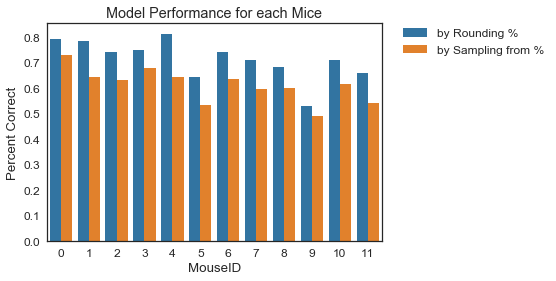

In [310]:
sns.barplot(x = 'MouseID', y = 'Perf', data = model_perf, hue = 'Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Model Performance for each Mice')
plt.ylabel('Percent Correct')

In [303]:
print(summary)

                   mean   se_mean        sd         2.5%          25%  \
betam          1.349881  0.009802  0.536895     0.195305     1.040616   
alpham        -0.052938  0.004975  0.224915    -0.497554    -0.187483   
betasd         1.901523  0.010499  0.490103     1.209077     1.554032   
alphasd        0.715895  0.007172  0.214679     0.421750     0.562940   
betas[0]       2.938200  0.003555  0.194703     2.565920     2.810934   
betas[1]       2.585067  0.003023  0.165581     2.266254     2.470874   
betas[2]       2.450463  0.002794  0.153034     2.147985     2.347774   
betas[3]       2.319335  0.002435  0.133391     2.054726     2.227962   
betas[4]      -3.371977  0.009261  0.441901    -4.280595    -3.669902   
betas[5]       1.075571  0.003253  0.178190     0.737314     0.952211   
betas[6]       2.384340  0.003491  0.191234     2.024669     2.250436   
betas[7]       1.491582  0.002443  0.133832     1.231422     1.401789   
betas[8]       1.861367  0.004949  0.271095     1.3

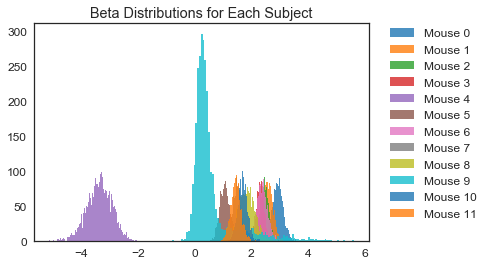

In [298]:
for s in np.arange(NS):
    plt.hist(extract['betas'][:,s], 100, alpha = 0.8, label = 'Mouse {:d}'.format(s))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Beta Distributions for Each Subject')

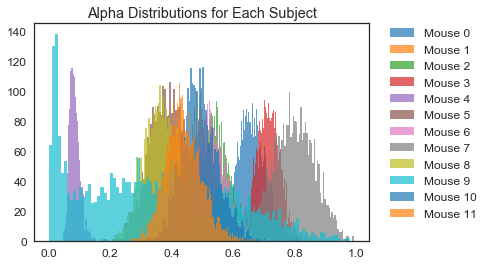

In [10]:
for s in np.arange(NS):
    plt.hist(phi_approx(extract['alphas'][:,s]), 100, alpha = 0.7, label = 'Mouse {:d}'.format(s))

    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Alpha Distributions for Each Subject')

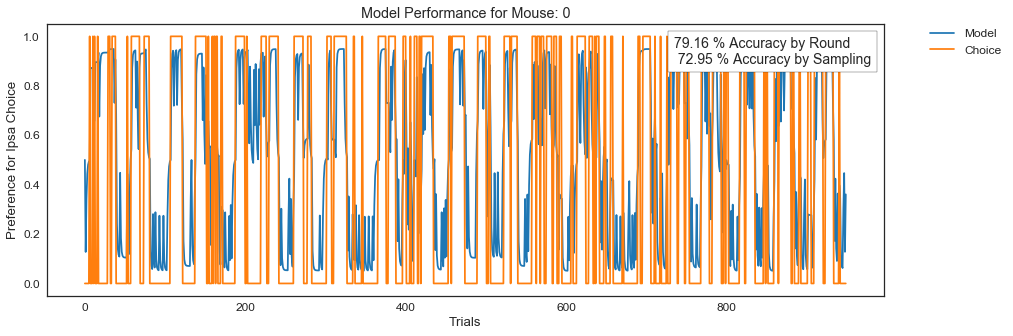

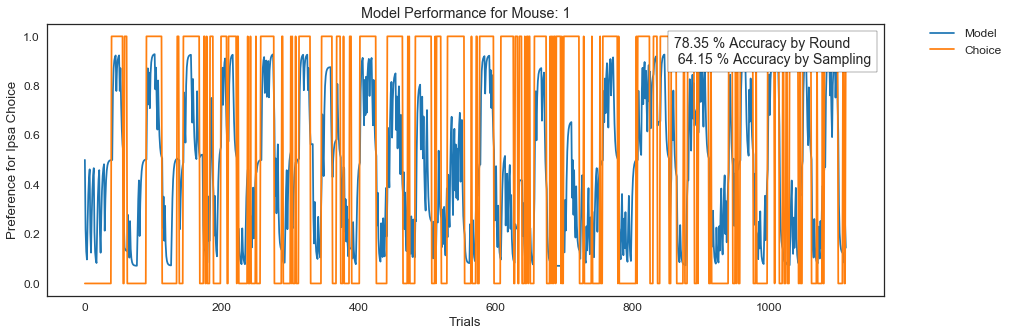

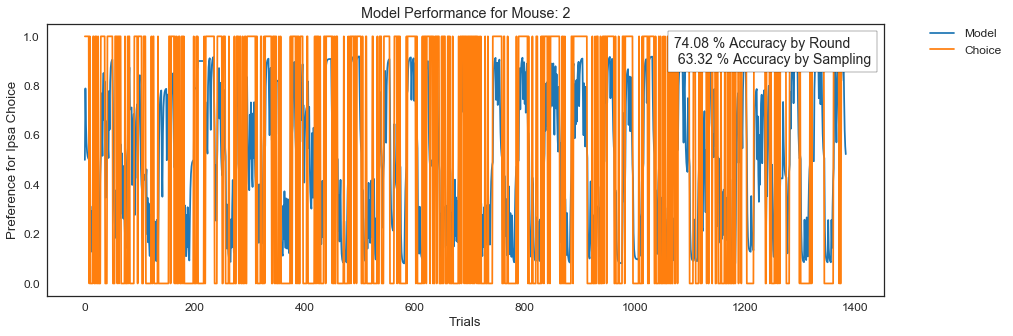

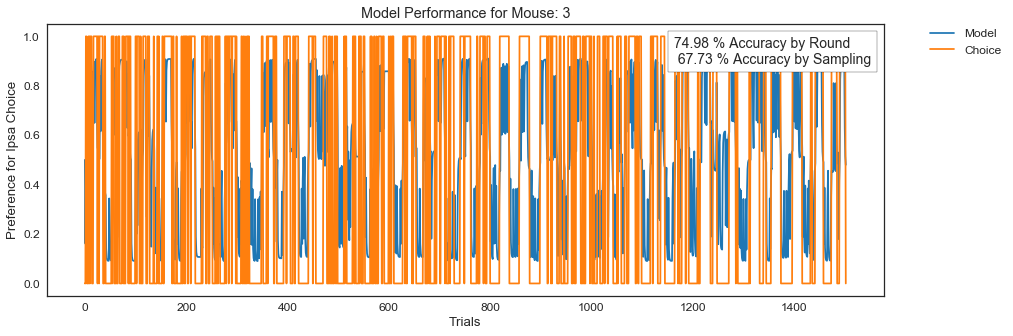

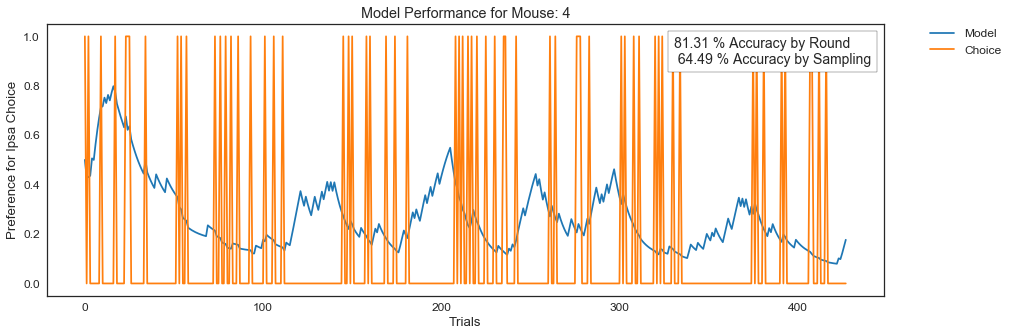

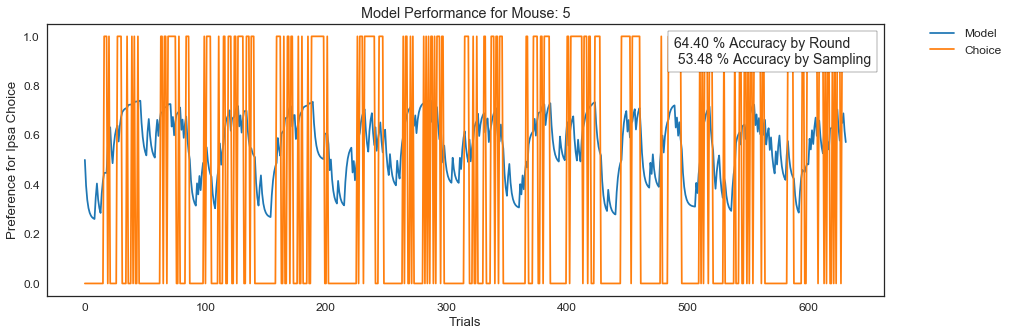

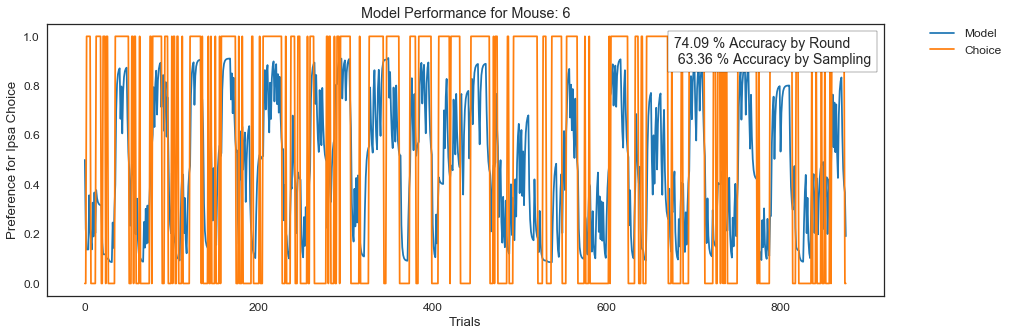

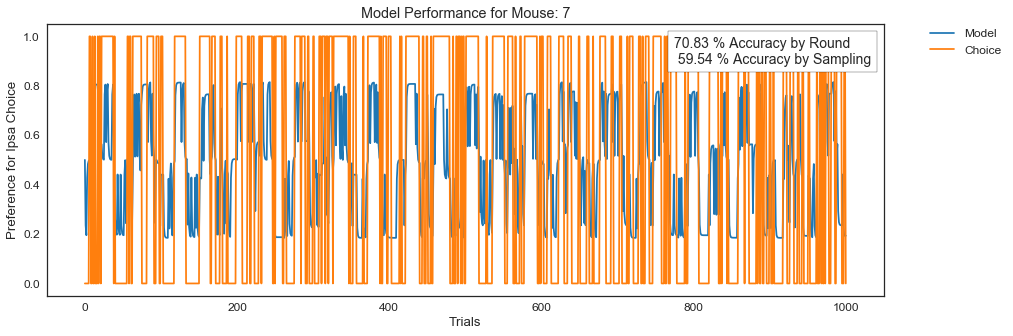

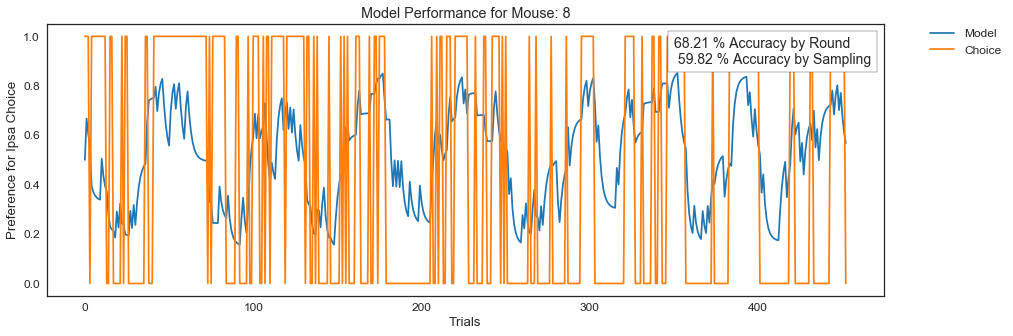

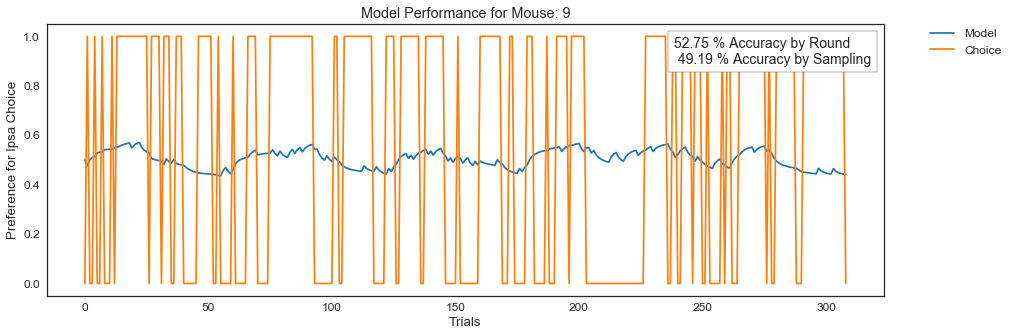

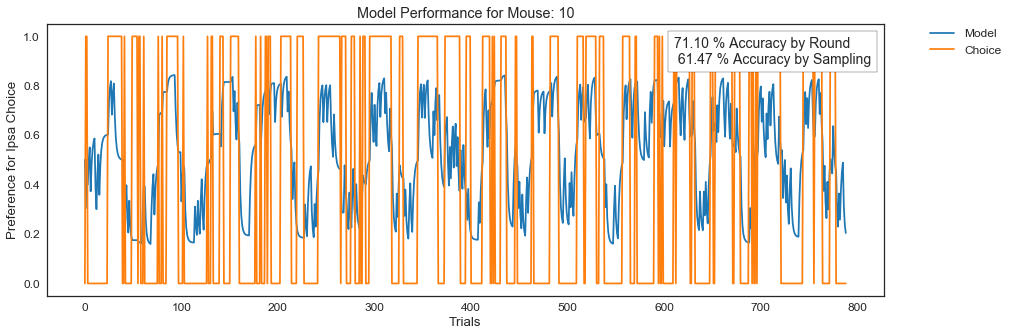

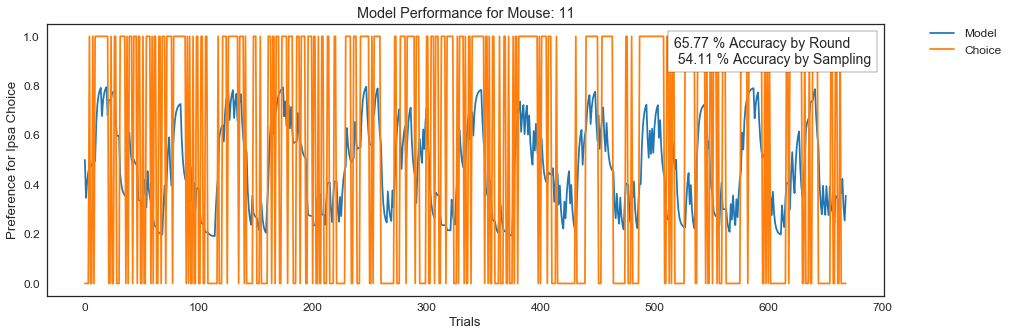

In [304]:

for s in np.arange(NS):

    fig = plt.figure(figsize= (15, 5))
    plt.plot(np.mean(prob_ipsa[:, s,:NT_all[s]], axis = 0), label = 'Model')
#     plt.plot(_Q_i[s, :NT_all[s]], label = 'Q_ipsa')
#     plt.plot(_Q_c[s, :NT_all[s]], label = 'Q_contra')
    plt.plot(c[s,:NT_all[s]], label = 'Choice')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.xlabel('Trials')
    plt.ylabel('Preference for Ipsa Choice')
    plt.title('Model Performance for Mouse: {:d}'.format(s))
    p_corr = AnchoredText('{:.2f} % Accuracy by Round \n {:.2f} % Accuracy by Sampling'
                          .format(corr_rate[s] * 100, corr_rate2[s] * 100),
                      prop=dict(size=14), frameon=True,
                      loc=1,
                      )
    
    axes = plt.gca()
    axes.add_artist(p_corr)
    plt.savefig('data/plots/{:d}_model_perf.png'.format(s))
    
    

In [33]:
bar = np.exp(extract['betas'][:,s, np.newaxis] * Q_i[:, s, :NT_all[s+1]]) 

In [34]:
bar/foo

array([[ 0.5       ,  0.81443149,  0.65389149, ...,  0.5       ,
         0.5       ,  0.5       ],
       [ 0.5       ,  0.8782111 ,  0.66904113, ...,  0.5       ,
         0.5       ,  0.5       ],
       [ 0.5       ,  0.90551942,  0.64839276, ...,  0.5       ,
         0.5       ,  0.5       ],
       ..., 
       [ 0.5       ,  0.88620026,  0.62923104, ...,  0.5       ,
         0.5       ,  0.5       ],
       [ 0.5       ,  0.83420773,  0.66850213, ...,  0.5       ,
         0.5       ,  0.5       ],
       [ 0.5       ,  0.85587058,  0.63363027, ...,  0.5       ,
         0.5       ,  0.5       ]])

## debug code

In [ ]:
mini = {'NS':3, 'NT':4, 'NT_all':[1, 2, 4], 
                 'r':r[:3, :4], 'c':c[:3,:4]}
debug = sm.sampling(data=mini, iter=2, warmup=1, chains=1)
extract = debug.extract()
for k, v in mini.items(): extract[k] = v

extract['prob_c']
extract['c_hat']